In [1]:
import pandas as pd
from pandas import Timestamp
import numpy as np
import scipy.stats as stats
from datetime import datetime
from pytz import timezone

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import *

import itertools

from tqdm import tqdm_notebook as tqdm

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors
%matplotlib inline

sns.set_style('whitegrid')
pd.set_option('display.max_columns', 100)

In [2]:
full_history = pd.read_json('data/history_clean.json')

if full_history['timestamp'].max().tz is None:
    full_history['timestamp'] = pd.to_datetime(full_history['timestamp'], utc=True)
    full_history['timestamp'] = full_history['timestamp'].apply(lambda t: t.tz_convert('US/Pacific'))
    
full_history['timestamp_64'] = pd.DatetimeIndex(full_history['timestamp']).view('int64') // pd.Timedelta(1, unit='s')

In [ ]:
artists = pd.read_json('data/artists_clean.json')

In [3]:
def get_unique():
    unique_history = full_history.drop(['timestamp', 'timestamp_64', 'hour_decimal', 'weekday'], axis=1)
    return unique_history.drop_duplicates('id')

## What music do I *actually* like?

In [4]:
latest_day = full_history['timestamp'].max()
day_range = (latest_day - full_history['timestamp'].min()).days

In [5]:
history_timing = full_history[['id', 'timestamp_64']]

In [156]:
song_info = []

u = get_unique().reset_index(drop=True)

vocab = []

pbar = tqdm(total=len(u))

for song in u[['id', 'genres']].itertuples():
    listens = history_timing[history_timing['id'] == song.id]
    
    if song.genres:
        vocab.extend([genre.replace(' ', '') for genre in song.genres])
        
    spread = (listens['timestamp_64'].max() - listens['timestamp_64'].min()) / (60 * 60 * 24)
    
    distance = (latest_day.timestamp() - listens['timestamp_64'].max()) / (60 * 60 * 24)
    
    song_info.append([spread, distance, len(listens)])
    
    pbar.update()
    
pbar.close()
    
song_info = np.array(song_info)

A Jupyter Widget

In [183]:
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences

encoded_genres = []
vocab_size = len(np.unique(vocab))

for song in u['genres'].values:
    if song:
        a = []
        for genre in song:
            a.extend(one_hot(genre.replace(' ', ''), vocab_size))
            
        encoded_genres.append(a)
    else:
        encoded_genres.append([])
        
max_sequences = max(list(map(len, encoded_genres)))
padded_docs = pad_sequences(encoded_genres, maxlen=max_sequences, padding='post')

In [184]:
padded_docs.shape

(7648, 31)

In [214]:
numeric = ['acousticness', 'danceability', 'duration', 'energy', 'explicit', 'key', 'log_loudness',
          'mode', 'popularity', 'speechiness', 'tempo', 'time_signature', 'valence']

X = u[numeric].reset_index(drop=True)

X = preprocessing.minmax_scale(X, axis=1)
X = np.concatenate([X, padded_docs], axis=1)

y = pd.DataFrame(song_info, columns=['spread', 'distance', 'listens'])
X.shape, y.shape

((7648, 44), (7648, 3))

In [215]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
X_train.shape, y_train.shape

((5353, 44), (5353, 3))

In [228]:
branchA = Sequential()
branchA.add(Embedding(vocab_size, 16, input_length=padded_docs.shape[1]))
branchA.add(Flatten())
branchA.add(Dense(3))

branchB = Sequential()
branchB.add(Dense(13, input_shape=(13,)))
branchB.add(Activation('sigmoid'))
branchB.add(Dense(6))

model = Sequential()
model.add(Merge([branchA, branchB], mode='concat'))
model.add(Dense(3))

model.compile(optimizer='adam',
              loss='mse',
              metrics=['acc'])

history = model.fit([X_train[:, -padded_docs.shape[1]:], X_train[:, :-padded_docs.shape[1]]], y_train, epochs=30)

/Users/alex/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  if sys.path[0] == '':


Epoch 1/30
5353/5353 [==============================] - 2s 324us/step - loss: 3063.9622 - acc: 0.6802
Epoch 2/30
5353/5353 [==============================] - 1s 104us/step - loss: 1731.2749 - acc: 0.7947
Epoch 3/30
5353/5353 [==============================] - 1s 111us/step - loss: 1703.3248 - acc: 0.79470s - loss: 177
Epoch 4/30
5353/5353 [==============================] - 1s 97us/step - loss: 1693.9888 - acc: 0.7947
Epoch 5/30
5353/5353 [==============================] - 1s 99us/step - loss: 1682.3014 - acc: 0.7947
Epoch 6/30
5353/5353 [==============================] - 1s 113us/step - loss: 1672.6950 - acc: 0.7947
Epoch 7/30
5353/5353 [==============================] - 1s 95us/step - loss: 1661.4001 - acc: 0.7947
Epoch 8/30
5353/5353 [==============================] - 1s 105us/step - loss: 1651.5452 - acc: 0.7947
Epoch 9/30
5353/5353 [==============================] - 1s 97us/step - loss: 1642.2484 - acc: 0.7947
Epoch 10/30
5353/5353 [==============================] - 1s 109us/step -

2295/2295 [==============================] - 1s 304us/step
0.78474945526


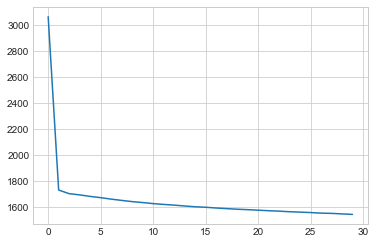

In [229]:
acc = model.evaluate([X_test[:, -padded_docs.shape[1]:], X_test[:, :-padded_docs.shape[1]]], y_test)[1]

print(acc)

plt.plot(history.history['loss'])

In [200]:
song = u[u['name'] == 'SUMMER']
song

,acousticness,album,artists,danceability,duration,energy,explicit,genres,id,key,log_loudness,mode,name,popularity,speechiness,tempo,time_signature,valence
379,0.847,SATURATION II,[1Bl6wpkWCQ4KVgnASpvzzA],0.497,3.41565,0.55,1,"[hip hop, indie r&b, rap, underground hip hop]",66dQdXAbtuPdSasezCQVZE,8,1.964311,1,SUMMER,65,0.0257,80.0,4,0.542


In [219]:
y.iloc[song.index]

,spread,distance,listens
379,169.647917,16.018056,38.0


In [226]:
model.predict([padded_docs[song.index], song[numeric]])

array([[  0.59753418,  42.82969666,   1.07978642]], dtype=float32)

In [213]:
stats.describe(model.predict([X_test[:, -padded_docs.shape[1]:], X_test[:, :-padded_docs.shape[1]]]))

DescribeResult(nobs=2295, minmax=(array([-1.32842612], dtype=float32), array([ 8.53903961], dtype=float32)), mean=array([ 2.10937214], dtype=float32), variance=array([ 1.28929579], dtype=float32), skewness=array([ 1.29618573], dtype=float32), kurtosis=array([ 3.60226583], dtype=float32))